In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
df = pd.read_csv('food_review.csv',engine='python')

In [ ]:
df.shape

(40500, 3)

In [ ]:
df.tail()

,Unnamed: 0,Text,Score
40495,40495,This is the second Beaba freezer tray that we'...,5
40496,40496,"The other, 5-star, review, must be from a shil...",1
40497,40497,Perfect for pills and capsules for medications...,5
40498,40498,"Sure, the first ingredient on this cereal is w...",2
40499,40499,I waited long and with bated breath for Amazon...,5


In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [ ]:
df.head()

,Text,Score
0,I bought these from a large chain pet store. a...,1
1,"This soup is incredibly good! But honestly, I...",5
2,Our family loves these tasty and healthy sesam...,5
3,The local auto shop offers this free to it cus...,4
4,I brought 2 bottles. One I carry in my pocket...,5


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
corpus=[]

In [ ]:
for i in range(0,3150):
    
    #replace non-letter with space
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i] )
    
    #convert all to lower case
    review=review.lower()
    
    #split
    review=review.split()
    
    #stemming and Lemmanization
    ps=PorterStemmer()
    lm = WordNetLemmatizer()
    
    #review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = [lm.lemmatize(word) for word in review if word not in set(stopwords.words('english'))] 
    review=' '.join(review)
    corpus.append(review)

In [ ]:
final_df = df[df["Score"]!=3]
final_df.shape

(32397, 2)

In [ ]:
final_df["Score"] = final_df["Score"].apply(lambda x : 1 if x>3 else 0)

In [ ]:
final_df['Score'].value_counts()

1    16223
0    16174
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

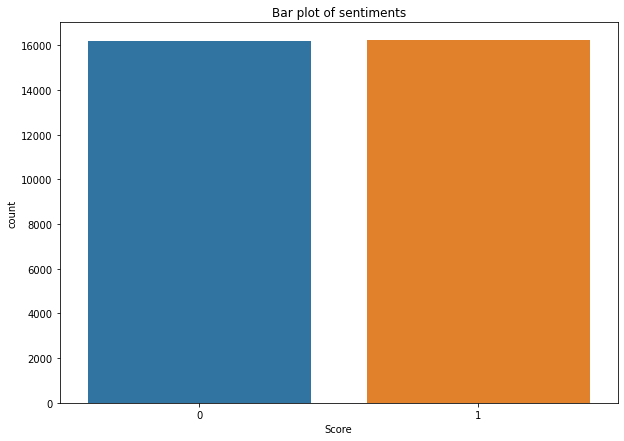

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(final_df['Score'])
plt.title("Bar plot of sentiments")

In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
final_df['Text'] = final_df['Text'].apply(lambda x: preprocess_text(x))

In [ ]:
final_df['Text'].head()

0    buy large chain pet store read review check ba...
1    soup incredibly good honestly look better deal...
2    family love tasty healthy sesame honey almonds...
3    local auto shop offer free customers try twice...
4    bring bottle one carry pocket home fell love v...
Name: Text, dtype: object

In [ ]:
train_df, test_df = train_test_split(final_df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (25917, 2)
Test data size :  (6480, 2)


In [ ]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 1691
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [ ]:
embedding_vecor_length = 231
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1691, 231)         1386231   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               132800    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,519,132
Trainable params: 1,519,132
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train, epochs=1, batch_size=64, validation_split=0.2)

324/324 [==============================] - 67s 144ms/step - loss: 0.5222 - accuracy: 0.7367 - val_loss: 0.3470 - val_accuracy: 0.8540


In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Score']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.8487654320987654
F1-score:  0.8429487179487181
Confusion matrix:


array([[2870,  370],
       [ 610, 2630]])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3240
           1       0.88      0.81      0.84      3240

    accuracy                           0.85      6480
   macro avg       0.85      0.85      0.85      6480
weighted avg       0.85      0.85      0.85      6480



In [ ]:
df["Text"] = df["Text"].apply(preprocess_text)